## Task 1: Model comparison
In this exercise, we compare the performance of several most popular machine learning models on a toy classification task.

In [5]:
# We start importing some modules and running some magic commands
%matplotlib inline

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import time

from scipy import stats

# Machine Learning library. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## split dataset into test set, train set and unlabel pool 

In [6]:
def split(X, y, train_size, test_size): 
    X_train, X_pool, y_train, y_pool = train_test_split( 
        X, y, train_size = train_size, random_state=42) 
    unlabel, X_test, label, y_test = train_test_split( 
        X_pool, y_pool, test_size = test_size, random_state=42) 
    return X_train, y_train, X_test, y_test, unlabel, label 

def create_dataset():
    X, y = make_classification(n_samples=1250,
                               n_features=2, 
                               n_redundant=0, 
                               n_informative=2,
                               random_state=1, 
                               n_clusters_per_class=1)

    rng = np.random.RandomState(2)
    X += 3*rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    X = StandardScaler().fit_transform(X)
    
    return X,y


## Now consider the following families of models we have seen in class.

In [7]:
X,y = create_dataset()

# specify classifiers
names = [
         "Decision Tree", 
         "Random Forest", 
         "AdaBoost",
         "Logistic Regression",
         "LDA",
         "Naive Bayes",
         "Neural Net", 
         "Gaussian Process",
         "RBF SVM"
        ]

classifiers = [ 
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),S
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    SVC(gamma=2, C=1)
]


## Setting up the training process

In [8]:
num_samples = X.shape[0]
incremental_train_size = 100
init_train_ratio = 0.04
test_ratio = 0.20

X_INIT, Y_INIT, X_TEST, Y_TEST, X_UNLABELED, Y_UNLABELED = split( 
            X,y, init_train_ratio, test_ratio) 


ac = np.zeros((num_trials, num_batches+2, len(classifiers)))
tc = np.zeros((num_trials, num_batches+2, len(classifiers)))
ne_incremental = [incremental_train_size + i * incremental_train_size for i in range(num_batches+1)]
ne = [X_INIT.shape[0]] + ne_incremental

print(ne)


[50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


## Now, following the demo code we provided in the exercise, to train the following models.

trial 1 / 3
trial 2 / 3
trial 3 / 3
1
2
3
4
5
6
7
8
9


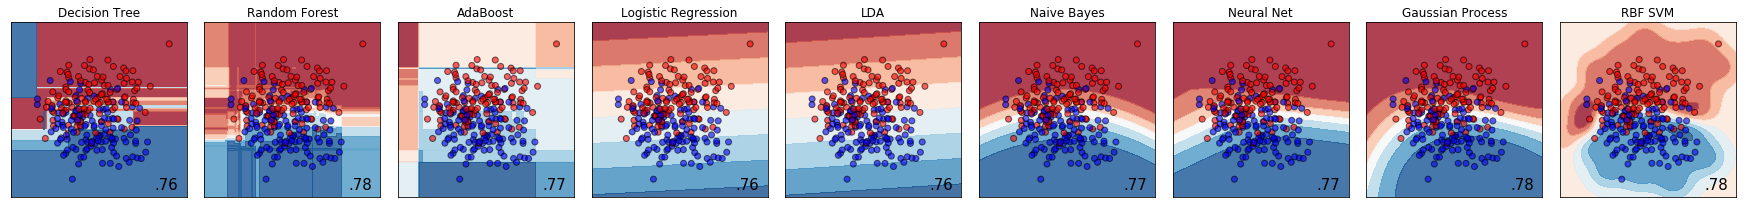

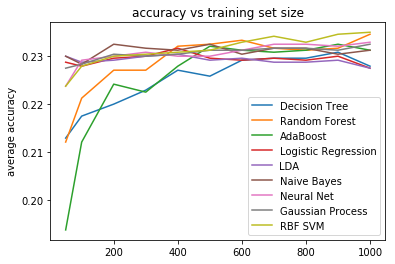

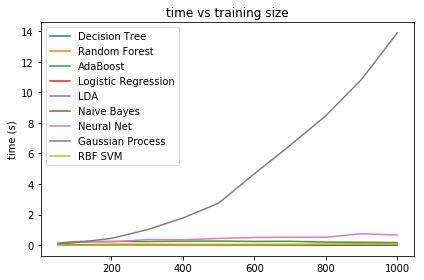

In [9]:
num_trials = 3
num_batches = int(num_samples*(1-test_ratio-init_train_ratio)/incremental_train_size)


figure = plt.figure(figsize=(27, 3))

subplotID = 1

# run each models n_trials times and take the average of their accuracy 
for i in range(num_trials): 
    print('trial', i+1, '/', num_trials)
    
    X_train = X_INIT.copy()
    y_train = Y_INIT.copy()
    X_test = X_TEST.copy()
    y_test = Y_TEST.copy()
    X_pool = X_UNLABELED.copy()
    y_pool = Y_UNLABELED.copy()


    for j in range(num_batches+2):
#         print('trial', i+1, '/', num_trials, 'round', j, '/', num_batches+1)

        # randomly sampling incremental_train_size points
        if j == 0:
            increment = 0
        if j == 1:
            increment = incremental_train_size-X_train.shape[0]
        if j > 1:
            increment = incremental_train_size

        query_idx = np.random.choice(range(len(X_pool)), size=increment, replace=False)

        X_new, y_new = X_pool[query_idx], y_pool[query_idx]
        X_train = np.concatenate((X_train, X_new))
        y_train = np.concatenate((y_train, y_new))

        # update the remaining unlabeled pool
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        

        # train model 
        # iterate over classifiers
        k=0
        for name, clf in zip(names, classifiers):
            start = time.process_time()
            clf.fit(X_train, y_train) 
            #print(y_pool.shape[0])

            traintime = time.process_time() - start
            score = clf.score(X_test, y_test)
            
            ac[i][j][k] = score
            tc[i][j][k] = traintime
            k +=1
            # plot the dataset
            cm = plt.cm.RdBu
            cm_bright = ListedColormap(['#FF0000', '#0000FF'])

            # plot decision boundary for the last trial

            if i == num_trials-1 and j == num_batches+1:
                print(subplotID)
                ax = plt.subplot(1, len(classifiers) + 1, subplotID)
                
                x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
                y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
                h = .02  # step size in the mesh
                xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                     np.arange(y_min, y_max, h))

                # Plot the decision boundary. For that, we will assign a color to each
                # point in the mesh [x_min, x_max]x[y_min, y_max].
                if hasattr(clf, "decision_function"):
                    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                else:
                    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

                # Put the result into a color plot
                Z = Z.reshape(xx.shape)
                ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#                 # Plot the training points
#                 ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                            edgecolors='k')
                # Plot the testing points
                ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                           edgecolors='k', alpha=0.6)

                ax.set_xlim(xx.min(), xx.max())
                ax.set_ylim(yy.min(), yy.max())
                ax.set_xticks(())
                ax.set_yticks(())
                ax.set_title(name)
                ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                        size=15, horizontalalignment='right')
                subplotID += 1

plt.tight_layout()
plt.show()

plt.figure()
#accuracy vs training size
ac_lines = plt.plot(ne, np.mean(ac, axis=0).tolist())
plt.legend(ac_lines, names)
plt.ylabel('average accuracy')
plt.title('accuracy vs training set size')

plt.figure()
#time complexity vs training size
tc_lines = plt.plot(ne, np.mean(tc, axis=0).tolist())
plt.legend(tc_lines, names)
plt.ylabel('time (s)')
plt.title('time vs training size')

# figure = plt.figure(figsize=(10, 5))

# #accuracy vs training size
# ax_ac = plt.subplot(1, 2, 1)
# ac_lines = ax_ac.plot(ne, np.mean(ac, axis=0).tolist())
# ax_ac.legend(ac_lines, names)
# ax_ac.set_ylabel('accuracy')
# ax_ac.set_title('accuracy vs training size')

# #time complexity vs training size
# ax_tc = plt.subplot(1, 2, 2)
# tc_lines = ax_tc.plot(ne, np.mean(tc, axis=0).tolist())
# ax_tc.legend(tc_lines, names)
# ax_tc.set_ylabel('time (s)')
# ax_tc.set_title('time vs training size')

plt.tight_layout()
plt.show()


In [ ]:
print(ac_lines)
print(ac[0][0])